# déneigeuse application

Après avoir explicité la théorie, nous cherchons maintenant l'appliquer à un cas concrêt à la ville de monréal. Le but est de répartir les taches entre les différentes déneigeuses dans le but de parcourir Montréal le plus efficacement possible.

## Mise en place de l'application

In [224]:
#IMPORT
import osmnx as ox
import networkx as nx
import multiprocessing as mp

Le code ci-dessous est mis en commentaire dans le but d'éviter de récréer les graph à chaque fois, ce qui prend beaucoup de temps.

In [222]:
'''place1 = "Le Sud-Ouest, Montreal, Canada"
place2 = "LaSalle, Montreal, Canada" 
place3 = "Anjou, Montreal, Canada"
place4 = "Rivière-des-Prairies–Pointe-aux-Trembles, Montreal, Canada"
place5 = "L'Ile-Bizard–Sainte-Geneviève, Montreal, Canada"
place6 = "Ahuntsic-Cartierville, Montreal, Canada"
place7 = "L'Île-Bizard–Sainte-Geneviève, Montreal, Canada"
place8 = "Outremont, Montreal, Canada"
place9 = "Mercier–Hochelaga-Maisonneuve, Montreal, Canada"
place10 = "Borough of Lachine, Canada"
place11 = "Pierrefonds-Roxboro, Montreal, Canada"
place12 = "Verdun, Montreal, Canada"
place13 = "L'Île-Bizard–Sainte-Geneviève, Montreal, Canada"
place14 = "Montréal-Nord, Montreal, Canada"
place15 = "Montréal-Est, Montreal, Canada"
place16 = "Saint-Laurent, Montreal, Canada"
place17 = "Rosemont–La Petite-Patrie, Montreal, Canada"
place18 = "Ville-Marie, Montreal, Canada"
place19 = "Villeray–Saint-Michel–Parc-Extension, Montreal, Canada"

def create_save(

G = ox.graph_from_place(place1, network_type="walk")
G2 = ox.graph_from_place(place2, network_type="walk")
G3 = ox.graph_from_place(place3, network_type="walk")
ox.save_graphml(G3, 'data/graph3.graphml')
G4 = ox.graph_from_place(place4, network_type="walk")
ox.save_graphml(G4, 'data/graph4.graphml')
G5 = ox.graph_from_place(place5, network_type="walk")
ox.save_graphml(G5, 'data/graph5.graphml')
G6 = ox.graph_from_place(place6, network_type="walk")
ox.save_graphml(G6, 'data/graph6.graphml')
G7 = ox.graph_from_place(place7, network_type="walk")
ox.save_graphml(G7, 'data/graph7.graphml')
G8 = ox.graph_from_place(place8, network_type="walk")
ox.save_graphml(G8, 'data/graph8.graphml')
G9 = ox.graph_from_place(place9, network_type="walk")
ox.save_graphml(G9, 'data/graph9.graphml')
G10 = ox.graph_from_place(place10, network_type="walk")
ox.save_graphml(G10, 'data/graph10.graphml')
G11 = ox.graph_from_place(place11, network_type="walk")
ox.save_graphml(G11, 'data/graph11.graphml')
G12 = ox.graph_from_place(place12, network_type="drive_service")
ox.save_graphml(G12, 'data/graph12.graphml')
G13 = ox.graph_from_place(place13, network_type="walk")
ox.save_graphml(G13, 'data/graph13.graphml')
G14 = ox.graph_from_place(place14, network_type="walk")
ox.save_graphml(G14, 'data/graph14.graphml')
G15 = ox.graph_from_place(place15, network_type="walk")
ox.save_graphml(G15, 'data/graph15.graphml')
G16 = ox.graph_from_place(place16, network_type="walk")
ox.save_graphml(G16, 'data/graph16.graphml')
G17 = ox.graph_from_place(place17, network_type="walk")
ox.save_graphml(G17, 'data/graph17.graphml')
G18 = ox.graph_from_place(place18, network_type="walk")
ox.save_graphml(G18, 'data/graph18.graphml')
G19 = ox.graph_from_place(place19, network_type="walk")
ox.save_graphml(G19, 'data/graph19.graphml')

#ox.save_graphml(G, 'data/graph.graphml')
#ox.save_graphml(G2, 'data/graph2.graphml')

ox.plot_graph(ox.load_graphml('data/graph12.graphml'))'''

#G = ox.graph_from_place(place1, network_type="walk")
#ox.save_graphml(G3, 'data/graph.graphml')
G_1 = ox.load_graphml('data/graph.graphml')
G_2 = ox.load_graphml('data/graph2.graphml')
G_3 = ox.load_graphml('data/graph3.graphml')
G_4 = ox.load_graphml('data/graph4.graphml')
G_5 = ox.load_graphml('data/graph5.graphml')
G_6 = ox.load_graphml('data/graph6.graphml')
G_7 = ox.load_graphml('data/graph7.graphml')
G_8 = ox.load_graphml('data/graph8.graphml')
G_9 = ox.load_graphml('data/graph9.graphml')
G_10 = ox.load_graphml('data/graph10.graphml')
G_11 = ox.load_graphml('data/graph11.graphml')
G_12 = ox.load_graphml('data/graph12.graphml')
G_13 = ox.load_graphml('data/graph13.graphml')
G_14 = ox.load_graphml('data/graph14.graphml')
G_15 = ox.load_graphml('data/graph15.graphml')
G_16 = ox.load_graphml('data/graph16.graphml')
G_17 = ox.load_graphml('data/graph17.graphml')
G_18 = ox.load_graphml('data/graph18.graphml')
G_19 = ox.load_graphml('data/graph19.graphml')

L = [G_1, G_2, G_3, G_4, G_5, G_6, G_7, G_8, G_9, G_10, G_11, G_12, G_13, G_14, G_15, G_16, G_17, G_18, G_19]

#ox.plot_graph(G_1)

Notre idée ici est de séparer Montreal en fonction de ses 19 arrondissements, cela permet d'éviter le chevauchement entre deux zones, même si évidément des zones peuvent partager des routes. De plus cela permet une répartition optimale des déneigeuses.

In [229]:
def decomplexify(graph):
    node_list = graph.edges(data=True)
    to_graph = nx.Graph()
    for node in node_list:
        #Weight
        dist = node[2]["length"]
        one_way = node[2]["oneway"] 
        n1 = node[0]
        n2 = node[1]
        #Oriented graph
        to_graph.add_edge(n1, n2, weight = dist) 
    return to_graph

def to_gnx(graph):
    gnx = nx.Graph()
    for (a,b,c) in graph:
        gnx.add_edge(a,b, weight=c)
    return gnx

def decomplexify_tograph(osmnx):
    node_list = graph.edges(data=True)
    to_graph = []
    for node in node_list:
        #Weight
        dist = node[2]["length"]
        n1 = node[0]
        n2 = node[1]
        #Oriented graph
        to_graph.append(n1, n2, dist)
    return to_graph
    
#print(G_1.edges(data=True))

La fonction prend en entrée une liste de noeud avec plein d'informations qui ne nous sont pas forcément utiles. Le but ici est de  servir de la bibliothèque networkx qui nous donne accés à  plein de fonction pour nous facilier la tache sur les graph.

## MISE  EN PLACE DU DECOUPAGE
    

Le but ici est de séparer nos 19 arrondissements en zone qui pourront être attribuées à une déneigeuse. Soyons plus formel, nous disposons de 2200 déneigeneuses. Nous partons du principe que nous avons besoin de deux groupes de déneigeuse, un groupe pour le trottoir et un pour la route. Ce qui nous fais deux groupes de 1100 engins sachant nous avons 19 arrondissement, 1100 / 19 est environ égale à 57 déneigeuses trottoire et route par arrondissement. Il faut donc **découper nos 19 arrondissements en 57 zones**.

S'ils l'ont se place du point de vue de la théorie des graph cela n'est pas vraiment un découpage car cela reviendrais à supprimer des routes. Non, il faut donc mettre en place un algorithme qui regroupe les sommets du graph en communauté.

In [228]:
def edge_to_remove(g):
      
    d1 = nx.edge_betweenness_centrality(g)
    list_of_tuples = d1.items()
    max_edge = ()
    for key, value in sorted(list_of_tuples, key = lambda x:x[1], reverse = True):
        max_edge = key
        break
    
    return max_edge

def girvan_newman(g):
    connect_comp = nx.connected_components(g)
    lena = nx.number_connected_components(g)
    edges = g.edges()
    L_rem = []
    while (lena == 1):
        u, v = edge_to_remove(g)
        L_rem.append((u,v,edges[(u,v)]['weight']))
        g.remove_edge(u, v) 
        connect_comp = nx.connected_components(g)
        lena=nx.number_connected_components(g)
    return (connect_comp, L_rem)

G2 = nx.karate_club_graph()
communities = girvan_newman(G2.copy())

#print(G2.edges(data=True))

#for i in communities[0]:
 #   print(list(i))

#print(communities[1])
#print(len(list(communities)))



Pour créer des zones dans le graph nous avons décidé d'utiliser l'algorithme de Girvan Newman. Ce derniers à pour objectif de créer des communautés de noeud basée sur la centralité intermédiaire ou Betweenness centrality, qui peut se définir comme la centralité d'un noeud ou d'une arête dans un graph. Elle se calcule par le nombre de plus court chemins passant par cette arête entre deux noeud d'un graph et donc une arête avec une centralité intermédiaire élevée a donc une grande importance dans le transfert de donnés dans un réseau.

### explication de l'algorithme de Girvan Newman

1. On cherche l'arête à supprimer en cherchant celle qui a centralité intermédiaire la plus importante
2. On supprime cette arête
3. On réitère tant qu'il n'y a pas plusieurs communauté autrement dit plusieurs composantes connexes
4. On recalcule centralité intermédiaire, cela nous permet de nous assurer qu'au  moins une arrête à une centralité intermédiaire importante entre deux communautés

In [227]:
#Return a list of graph_nx witch match the component
def component_to_graph(components, graph_nx):
    graph_list = []
    for component in components[0]:
        graph_list.append(nx.subgraph(graph_nx, component).copy())
    #for (a, b, c) in components[1]:
     #   graph_list[0].add_edge(a,b, weight=c)
    return graph_list    

In [226]:
def split_in_two(graph_nx):
    L = component_to_graph(girvan_newman(graph_nx.copy()), graph_nx)
    R1 = []
    R2 = []
    #Convert to classical representation
    for u in L[0].edges(data=True):
        R1.append((u[0],u[1],u[2]['weight']))
    for u in L[1].edges(data=True):
        R2.append((u[0],u[1],u[2]['weight']))
    return (R1, R2)
    

In [225]:
def split_in_n(graph_nx):
    print("coucou")
    count = 1
    sub_graphs = [graph_nx]
    sub_graph_result = [None]
    while (count < 55):
        graph_nx_  =  sub_graphs.pop(0)
        (graph1, graph2) = split_in_two(graph_nx_)
        if (len(graph1) > 0):
            print("1")
            sub_graph_result.append(graph1)
            sub_graphs.append(to_gnx(graph1))
        if (len(graph2) > 0):
            print("2")
            sub_graph_result.append(graph2)
            sub_graphs.append(to_gnx(graph2))
        sub_graph_result.pop(0)
        count += 1
    return sub_graph_result

### EXPLICATION DU DECOUPAGE

C'est l'étape qui va nous permettre de séparer la ville en zone.

1. Mise en place de deux queue une qui sert pour le résultat, l'autres les calculs
2. Tant que l'on a pas le nombre de zone désiré on divise le graph en deux à l'aide de l'algorithme de Givann Newman
3. On vérifie que le graph n'est pas vide car il se peut que girvan newmann nous donne une composenante connexe à un seul noeud.
4. On ajoute les deux graph à la queue
5. On pop le graph du résultat qui vient d'être split en deux

In [17]:
gnxr = decomplexify(G_1)

In [79]:
R = split_in_n(gnxr, 55)

In [207]:
print(len(R))

55


In [248]:
R1 = []
for (a,b,c) in R[3]:
    R1.append((a,b))

In [249]:
ec = ['b' if (u,v) in R1 or (v,u) in R1  else 'r' for u, v, k in G_1.edges(keys=True)]

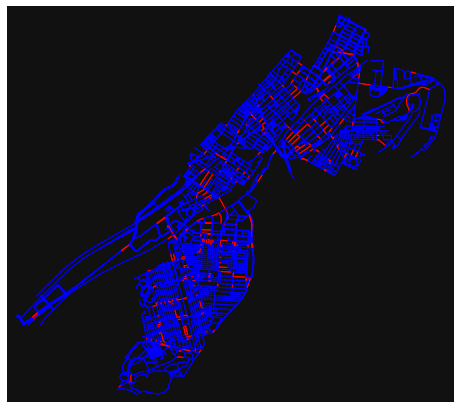

In [250]:
fig, ax = ox.plot_graph(G_1, node_color='w', node_edgecolor='k', node_size=0, 
                           node_zorder=3, edge_color=ec, edge_linewidth=1)

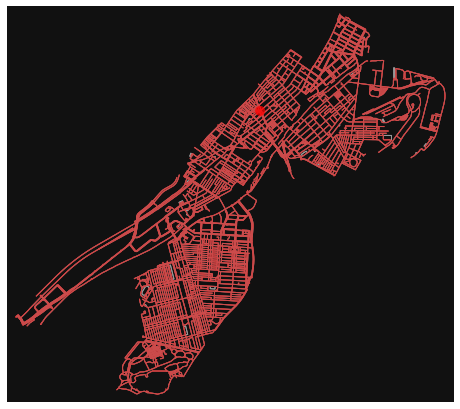

In [215]:
fig, ax = ox.plot_graph_route(G_1, path2, route_color='r',route_linewidth=1, node_size=0)

In [217]:
import pickle

def split_and_save(G, filename):
    sub_graphs = split_in_n(decomplexify(G), 55)
    with open(filename, "wb") as f:
        pickle.dump(sub_graphs, f)

In [231]:
nx = []
with open("graph1.txt", "rb") as f:
    nx = pickle.load(f)
    